# Fowl Escapades
### the basis of this work and majority of the code comes from the notebook kindly shared by Johnowithaker [here](https://zindi.africa/competitions/fowl-escapades/discussions/675) 


This notebook shows a quick example submission to the 'Fowl Escapades' challenge on Zindi. 

It's not necessarily a good submission, but it does take you through the whole process. Loading the data, processing the audio into features (spectrograms, in this case) and making a submission.

I hope it's useful :)

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


# Load the labels

I'm assuming you've extracted test.zip and train.zip, and downloaded the CSV files from Zindi.

Here we'll generate a couple of dataframes with the labels for train and paths to the images.

In [0]:
# !ls drive/My\ Drive/fowl/Train/

In [3]:
!ls

drive  sample_data


In [0]:
import pandas as pd

In [5]:
path = "drive/My Drive/fowl/"
sub = pd.read_csv(path+'SampleSubmission.csv')
NUM_S=8
TTA=10
sub.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,Bokmakierie,Black-backed Puffback,Southern Boubou,Black-headed Oriole,Fork-tailed Drongo,African Paradise Flycatcher,Sabota Lark,Eastern Clapper Lark,Rufous-naped Lark,Dark-capped Bulbul,Sombre Greenbul,Long-billed Crombec,African Reed Warbler,Rattling Cisticola,Levaillants Cisticola,Tawny-flanked Prinia,Karoo Prinia,Bar-throated Apalis,Green-backed Camaroptera,Chestnut-vented Warbler,Cape White-eye,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,01S9OX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,02CS12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,02LM3W,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0C3A2V,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [6]:
train = pd.read_csv(path+'Train.csv')
train.head()

,ID,common_name
0,MBMG2C,Ring-necked Dove
1,K8LJSB,Ring-necked Dove
2,OGD9L6,Ring-necked Dove
3,581PCQ,Ring-necked Dove
4,P91M1F,Ring-necked Dove


In [7]:
# This list will be useful later
birds = sub.columns[1:]
birds

Index(['Ring-necked Dove', 'Black Cuckoo', 'Red-chested Cuckoo',
       'Fiery-necked Nightjar', 'Green Wood Hoopoe', 'Crested Barbet',
       'Cape Batis', 'Olive Bushshrike', 'Orange-breasted Bushshrike',
       'Bokmakierie', 'Black-backed Puffback', 'Southern Boubou',
       'Black-headed Oriole', 'Fork-tailed Drongo',
       'African Paradise Flycatcher', 'Sabota Lark', 'Eastern Clapper Lark',
       'Rufous-naped Lark', 'Dark-capped Bulbul', 'Sombre Greenbul',
       'Long-billed Crombec', 'African Reed Warbler', 'Rattling Cisticola',
       'Levaillants Cisticola', 'Tawny-flanked Prinia', 'Karoo Prinia',
       'Bar-throated Apalis', 'Green-backed Camaroptera',
       'Chestnut-vented Warbler', 'Cape White-eye', 'Karoo Scrub Robin',
       'White-browed Scrub Robin', 'Cape Robin-Chat',
       'White-browed Robin-Chat', 'Chorister Robin-Chat',
       'Southern Double-collared Sunbird', 'White-bellied Sunbird',
       'African Pipit', 'African Rock Pipit', 'Cape Bunting'],
      d

In [0]:
# Add file names
train['file_name'] = path+"Train/"+train['ID']+'.mp3'
sub['file_name'] = path+"Test/"+sub['ID']+'.mp3'

# Generate features

There are many ways to tackle this challenge. Try deep learning on the audio, generate a spectrogram and treat this as an image classification task, use some signal processing tricks to look for close matches, try to extract meaningful features such as dominant frequencies.... It's up to you :)

This blog (https://towardsdatascience.com/extract-features-of-music-75a3f9bc265d) shows how to visualize different properties of the waveform, and some features you could use. 

For this example, I'll generate a square spectrogram and save as an image file - not a very elegant approach but let's see where it gets us.

In [0]:
import IPython.display as ipd
from matplotlib import pyplot as plt
import librosa

In [10]:
#listen to a sound
pth = train['file_name'].sample(1).values[0]
# pth=path+"Train/05XKMD.mp3"
ipd.Audio(pth)

(1025, 1795)
(1025, 1025)
drive/My Drive/fowl/Train/D0CL5X.png


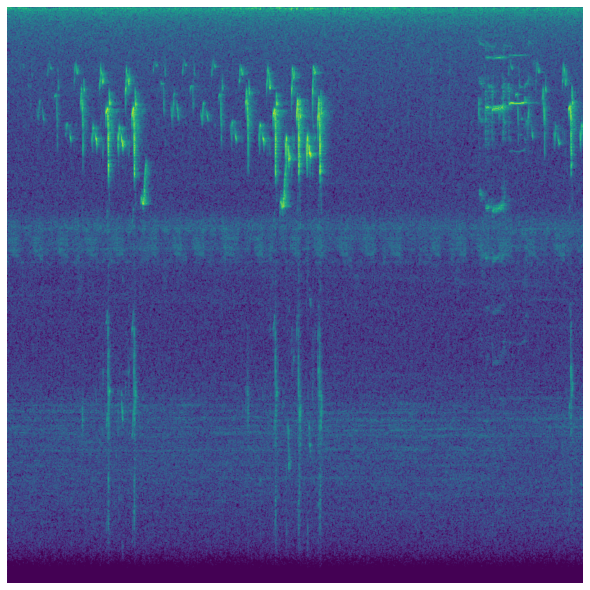

In [11]:
# Going from a sound to an image: spectrograms

def gen_spectrogram(path):
  x , sr = librosa.load(path)
  X = librosa.stft(x)
  print(X.shape)
  X=X[:,:]
  Xdb = librosa.amplitude_to_db(abs(X)[:,:min(1025, len(X[0]))])
  print(Xdb.shape)
  fig = plt.figure(frameon=False)
  fig.set_size_inches(8, 8)
  ax = plt.Axes(fig, [0., 0., 1., 1.])
  ax.set_axis_off()
  fig.add_axes(ax)
  ax.imshow(Xdb, aspect='auto')
  fig.savefig(path[:-4]+'.png', dpi=512//8)
  print(path[:-4]+'.png')

gen_spectrogram(pth)

In [0]:
import librosa
import librosa.display
import random

import numpy as np
from tqdm import tqdm_notebook
import os
import pickle

# from fastai import *
# from fastai.callbacks import *
# from fastai.vision import *
# from fastai.vision.data import *


def read_audio(conf, pathname, trim_long_data):
    y, sr = librosa.load(pathname, sr=conf.sampling_rate)
    # trim silence
    if 0 < len(y): # workaround: 0 length causes error
        y, _ = librosa.effects.trim(y) # trim, top_db=default(60)
    # make it unified length to conf.samples
    if len(y) > conf.samples: # long enough
        if trim_long_data:
            y = y[0:0+conf.samples]
    else: # pad blank
        padding = conf.samples - len(y)    # add padding at both ends
        offset = padding // 2
        y = np.pad(y, (offset, conf.samples - len(y) - offset), conf.padmode)
    return y


def audio_to_melspectrogram(conf, audio):
    spectrogram = librosa.feature.melspectrogram(audio, 
                                                 sr=conf.sampling_rate,
                                                 n_mels=conf.n_mels,
                                                 hop_length=conf.hop_length,
                                                 n_fft=conf.n_fft,
                                                 fmin=conf.fmin,
                                                 fmax=conf.fmax)
    spectrogram = librosa.power_to_db(spectrogram)
    spectrogram = spectrogram.astype(np.float32)
    return spectrogram


def show_melspectrogram(conf, mels, title='Log-frequency power spectrogram'):
    librosa.display.specshow(mels, x_axis='time', y_axis='mel', 
                             sr=conf.sampling_rate, hop_length=conf.hop_length,
                            fmin=conf.fmin, fmax=conf.fmax)
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.show()


def read_as_melspectrogram(conf, pathname, trim_long_data, debug_display=False):
    x = read_audio(conf, pathname, trim_long_data)
    mels = audio_to_melspectrogram(conf, x)
    if debug_display:
        IPython.display.display(IPython.display.Audio(x, rate=conf.sampling_rate))
        show_melspectrogram(conf, mels)
    return mels


class conf:
    sampling_rate = 44100
    duration = 2 # sec
    hop_length = 347*duration # to make time steps 128
    fmin = 20
    fmax = sampling_rate // 2
    n_mels = 128
    n_fft = n_mels * 20
    padmode = 'constant'
    samples = sampling_rate * duration


def get_default_conf():
    return conf

    
def set_fastai_random_seed(seed=42):
    # https://docs.fast.ai/dev/test.html#getting-reproducible-results

    # python RNG
    random.seed(seed)

    # pytorch RNGs
    import torch
    torch.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    if torch.cuda.is_available(): torch.cuda.manual_seed_all(seed)

    # numpy RNG
    import numpy as np
    np.random.seed(seed)
def mono_to_color(X, mean=None, std=None, norm_max=None, norm_min=None, eps=1e-6):
    # Stack X as [X,X,X]
    X = np.stack([X, X, X], axis=-1)

    # Standardize
    mean = mean or X.mean()
    X = X - mean
    std = std or X.std()
    Xstd = X / (std + eps)
    _min, _max = Xstd.min(), Xstd.max()
    norm_max = norm_max or _max
    norm_min = norm_min or _min
    if (_max - _min) > eps:
        # Normalize to [0, 255]
        V = Xstd
        V[V < norm_min] = norm_min
        V[V > norm_max] = norm_max
        V = 255 * (V - norm_min) / (norm_max - norm_min)
        V = V.astype(np.uint8)
    else:
        # Just zero
        V = np.zeros_like(Xstd, dtype=np.uint8)
    return V


def convert_wav_to_image(df, source):
    X = []
    for i, row in tqdm_notebook(df.iterrows()):
        x = read_as_melspectrogram(conf, source/str(row.fname), trim_long_data=False)
        x_color = mono_to_color(x)
        X.append(x_color)
    return X

# Going from a sound to an image: spectrograms

def save_as_pkl_binary(obj, filename):
    """Save object as pickle binary file.
    Thanks to https://stackoverflow.com/questions/19201290/how-to-save-a-dictionary-to-a-file/32216025
    """
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)


def load_pkl(filename):
    """Load pickle object from file."""
    with open(filename, 'rb') as f:
        return pickle.load(f)

(1025, 550)
(1025, 550)
drive/My Drive/fowl/Train/K8ZJFC.png


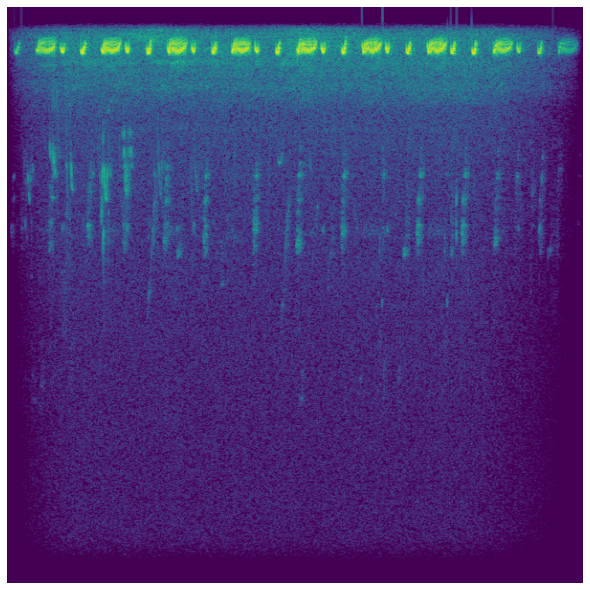

In [13]:
def gen_melspectrogram(path):
  x , sr = librosa.load(path)
  x = read_as_melspectrogram(conf, path, trim_long_data=False)
  X = mono_to_color(x)
  # print(X.shape)
  # X=X[:,:]
  # Xdb = librosa.amplitude_to_db(abs(X)[:,:min(1025, len(X[0]))])
  # print(Xdb.shape)
  # fig = plt.figure(frameon=False)
  # fig.set_size_inches(24,8)
  # ax = plt.Axes(fig, [0., 0., 1., 1.])
  # ax.set_axis_off()
  # fig.add_axes(ax)
  # ax.imshow(X, aspect='auto')
  # fig.savefig(path[:-4]+'_MEL.png', dpi=512//4)
  # print(path[:-4]+'.png')
  save_as_pkl_binary(X, path[:-4]+'_MEL.pkl')

pth = train['file_name'].sample(1).values[0]
gen_spectrogram(pth)
gen_melspectrogram(pth)
# pth=path+"Train/05XKMD.mp3"
ipd.Audio(pth)

In [14]:
train["file_name_MEL"]  = [i[:-4]+"_MEL.pkl" for i in train["file_name"] ]
train.head()

,ID,common_name,file_name,file_name_MEL
0,MBMG2C,Ring-necked Dove,drive/My Drive/fowl/Train/MBMG2C.mp3,drive/My Drive/fowl/Train/MBMG2C_MEL.pkl
1,K8LJSB,Ring-necked Dove,drive/My Drive/fowl/Train/K8LJSB.mp3,drive/My Drive/fowl/Train/K8LJSB_MEL.pkl
2,OGD9L6,Ring-necked Dove,drive/My Drive/fowl/Train/OGD9L6.mp3,drive/My Drive/fowl/Train/OGD9L6_MEL.pkl
3,581PCQ,Ring-necked Dove,drive/My Drive/fowl/Train/581PCQ.mp3,drive/My Drive/fowl/Train/581PCQ_MEL.pkl
4,P91M1F,Ring-necked Dove,drive/My Drive/fowl/Train/P91M1F.mp3,drive/My Drive/fowl/Train/P91M1F_MEL.pkl


In [15]:
# This takes a long time to run, and you might have to do it in batches. Save the spectrogras for future runs!

for i, pth in tqdm_notebook(enumerate(np.concatenate([train['file_name'].values, sub['file_name'].values]))):
  try:
    # print(i*100//(len(sub)+len(train)), '% done')
    # Check if we've already generated a spectrogram, and if not, make one
    if not os.path.isfile(pth[:-4]+'_MEL.pkl'):
      # plt.clf()
      gen_melspectrogram(pth)
    # ipd.clear_output(wait=False)
    # plt.close()
  except:pass

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


In [16]:
train.head()

,ID,common_name,file_name,file_name_MEL
0,MBMG2C,Ring-necked Dove,drive/My Drive/fowl/Train/MBMG2C.mp3,drive/My Drive/fowl/Train/MBMG2C_MEL.pkl
1,K8LJSB,Ring-necked Dove,drive/My Drive/fowl/Train/K8LJSB.mp3,drive/My Drive/fowl/Train/K8LJSB_MEL.pkl
2,OGD9L6,Ring-necked Dove,drive/My Drive/fowl/Train/OGD9L6.mp3,drive/My Drive/fowl/Train/OGD9L6_MEL.pkl
3,581PCQ,Ring-necked Dove,drive/My Drive/fowl/Train/581PCQ.mp3,drive/My Drive/fowl/Train/581PCQ_MEL.pkl
4,P91M1F,Ring-necked Dove,drive/My Drive/fowl/Train/P91M1F.mp3,drive/My Drive/fowl/Train/P91M1F_MEL.pkl


In [17]:
# Checking that the spectrograms were generated successfully:
import glob
ims = glob.glob(path+'Train/*.pkl')
print(len(ims), len(train))

1856 1857


In [18]:
ims[0];train.iloc[0]

ID                                                 MBMG2C
common_name                              Ring-necked Dove
file_name            drive/My Drive/fowl/Train/MBMG2C.mp3
file_name_MEL    drive/My Drive/fowl/Train/MBMG2C_MEL.pkl
Name: 0, dtype: object

In [19]:
# If you stopped the process early and want to try with only a few spectrograms, this will only use the ones that have been generated
train['img_path'] = train['file_name_MEL']
train = train.loc[train.img_path.isin(ims)]
len(train)

1856

In [20]:
# Similarly, test now has rows for files that have had spectrograms created.
sub['img_path'] = sub['file_name'].str[:-4]+'_MEL.pkl'
ims = glob.glob(path+'Test/*.pkl')
test = sub.loc[sub.img_path.isin(ims)]
print(len(sub), len(test))

911 911


In [21]:
train.head()

,ID,common_name,file_name,file_name_MEL,img_path
0,MBMG2C,Ring-necked Dove,drive/My Drive/fowl/Train/MBMG2C.mp3,drive/My Drive/fowl/Train/MBMG2C_MEL.pkl,drive/My Drive/fowl/Train/MBMG2C_MEL.pkl
1,K8LJSB,Ring-necked Dove,drive/My Drive/fowl/Train/K8LJSB.mp3,drive/My Drive/fowl/Train/K8LJSB_MEL.pkl,drive/My Drive/fowl/Train/K8LJSB_MEL.pkl
2,OGD9L6,Ring-necked Dove,drive/My Drive/fowl/Train/OGD9L6.mp3,drive/My Drive/fowl/Train/OGD9L6_MEL.pkl,drive/My Drive/fowl/Train/OGD9L6_MEL.pkl
3,581PCQ,Ring-necked Dove,drive/My Drive/fowl/Train/581PCQ.mp3,drive/My Drive/fowl/Train/581PCQ_MEL.pkl,drive/My Drive/fowl/Train/581PCQ_MEL.pkl
4,P91M1F,Ring-necked Dove,drive/My Drive/fowl/Train/P91M1F.mp3,drive/My Drive/fowl/Train/P91M1F_MEL.pkl,drive/My Drive/fowl/Train/P91M1F_MEL.pkl


# Modelling

I use a model pre-trained on imagenet, and throw the spectrograms at it. Not the most elegant approach, but it will do for now!

In [0]:
from fastai.vision import *

In [0]:
# !pip install pretrainedmodels
# import pretrainedmodels
# def srx50(pretrained=True,**kwargs):
#     return pretrainedmodels.se_resnext50_32x4d(num_classes=1000,pretrained='imagenet')

# def srx101(pretrained=True,**kwargs):
#     return pretrainedmodels.se_resnext101_32x4d(num_classes=1000,pretrained='imagenet')

# def iv3(pretrained=True,**kwargs):
#     return pretrainedmodels.inceptionv3(num_classes=1000,pretrained='imagenet')

class Head(nn.Module):
    def __init__(self, f_in, num_classes=1000, p=0.0):
        super(Head, self).__init__()
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.dropout = nn.Dropout(p)
        self.fc = nn.Linear(f_in, num_classes)

    def forward(self, x):
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(self.dropout(x))
        return x

from sklearn.metrics import accuracy_score
def get_TTA(tta=TTA, ds="", score=False):
    a=[]
    if ds=="val":
        for i in range(tta):
            p, _ = learn.get_preds(DatasetType.Valid)
            if i==0: preds=p
            else: preds+=p
            acc = accuracy_score(np.argmax(to_np(p),1),to_np(_))
            # print(acc)
            a.append(acc)
        # print(a)
        print("avg\t", "min\t", "max\t", "median\t", "ensemble\t")
        ens = accuracy_score(np.argmax(to_np(preds),1),to_np(_))
        print(round(np.mean(a)*100,1),"\t", round(min(a)*100,1),"\t", round(max(a)*100,1),"\t", round(np.median(a)*100,1),"\t", round(ens*100, 1))
    else:
        for i in range(tta):
            p, _ = learn.get_preds(DatasetType.Test)
            if i==0:preds=p
            else:preds+=p
            ens=0
    return (preds/tta, _,ens)


def open_MEL(fn, convert_mode, after_open, num_s=NUM_S)->Image:
    # open
    # idx = CUR_X_FILES.index(fn.split('/')[-1])
    try: x = PIL.Image.fromarray(load_pkl(fn))
    except:
        print(fn)
        x = PIL.Image.new('RGB', (128, 128)).convert(convert_mode)

    # crop if longer then needed, otherwise non-centered padding
    time_dim, base_dim = x.size
    t_ = int(base_dim*num_s) # cropped or padded 

    if time_dim//num_s<128:
        pad_x = random.randint(0, t_ - time_dim)
#         bg_size = (N,)*1
        bg = np.zeros(shape=(128, t_,3))
        bg[:,pad_x:time_dim+pad_x] = x
        x = bg    
        
    else:
        crop_x = random.randint(0, time_dim - t_)
        x = x.crop([crop_x, 0, crop_x+t_, base_dim])    
    # standardize
    return Image(pil2tensor(x, np.float32).div_(255))

vision.data.open_image = open_MEL

In [0]:
np.random.seed(42)

tfms = get_transforms( do_flip=False, flip_vert=False, max_rotate=5, 
                               max_lighting=0.1, max_zoom=1.1, max_warp=0.1,
                                 p_affine=1.0, p_lighting=1.0
                              )
data = ImageDataBunch.from_df(path="", df=train[["img_path", "common_name"]], ds_tfms=tfms, 
                              size=(128,128*NUM_S), num_workers=4)\
  .split_by_rand_pct()\
  .label_from_df(cols='common_name')\
  .databunch(bs=16)\
  .normalize(imagenet_stats)

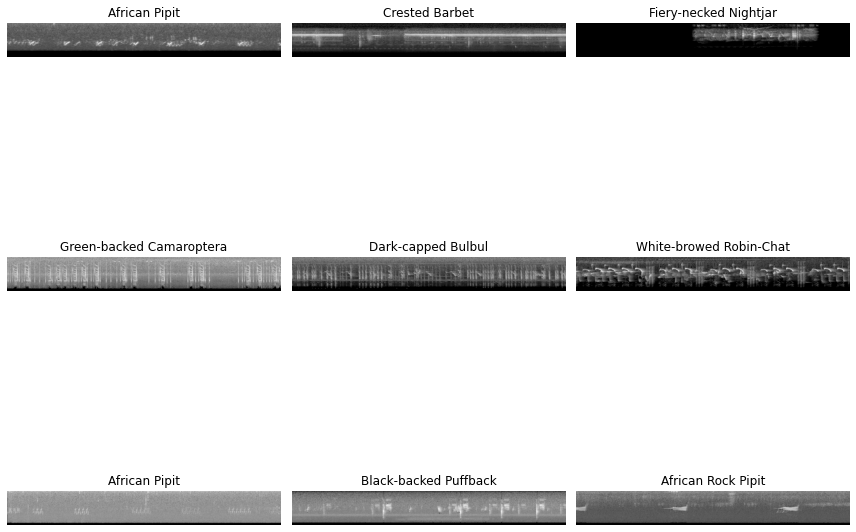

In [25]:
data.show_batch(rows=3)

In [26]:
# Create a learner and pick a learning rate
learn = cnn_learner(data, models.densenet121, metrics=[error_rate, accuracy, top_k_accuracy],
                    cut=-1,
                    custom_head=Head(512*2,data.c, 0.8),                   
                    ).mixup(0.1)
learn.unfreeze()
# learn.lr_find()
# learn.recorder.plot()

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/checkpoints/densenet121-a639ec97.pth


In [27]:
# Train the head of the model
lr =3e-4
learn.fit_one_cycle(200,lr, 
                    div_factor = 10,
                    )



epoch,train_loss,valid_loss,error_rate,accuracy,top_k_accuracy,time
0,5.002512,3.739421,0.949495,0.050505,0.232323,02:05
1,4.603461,3.588763,0.909091,0.090909,0.289562,00:23
2,4.335551,3.414256,0.861953,0.138047,0.333333,00:23
3,4.160819,3.273534,0.821549,0.178451,0.407407,00:23
4,3.920177,3.034541,0.767677,0.232323,0.545455,00:23
5,3.696482,2.833512,0.727273,0.272727,0.585859,00:23
6,3.507297,2.563620,0.680135,0.319865,0.656566,00:23
7,3.257280,2.365212,0.602694,0.397306,0.653199,00:23
8,2.996209,2.096000,0.552189,0.447811,0.754209,00:23
9,2.775246,1.925062,0.511784,0.488215,0.784512,00:23


Buffered data was truncated after reaching the output size limit.

In [28]:
(p_,_,e_) = get_TTA(tta=5 , ds="val")
(p_,_,e_) = get_TTA(tta=15 , ds="val")
(p_,_,e_) = get_TTA(tta=50 , ds="val")

avg	 min	 max	 median	 ensemble	
81.8 	 80.1 	 83.5 	 81.5 	 83.5


avg	 min	 max	 median	 ensemble	
81.5 	 80.1 	 83.2 	 81.5 	 83.8


avg	 min	 max	 median	 ensemble	
81.4 	 79.5 	 84.5 	 81.1 	 84.5


### An accuracy of 32% seems bad, but consider that this is across 40 classes. The model guesses the right bird in its top 5 guesses 60% of the time! You can boost this significantly with a little more training and a larger image size. This approach is crazy, but it kinda works!!!

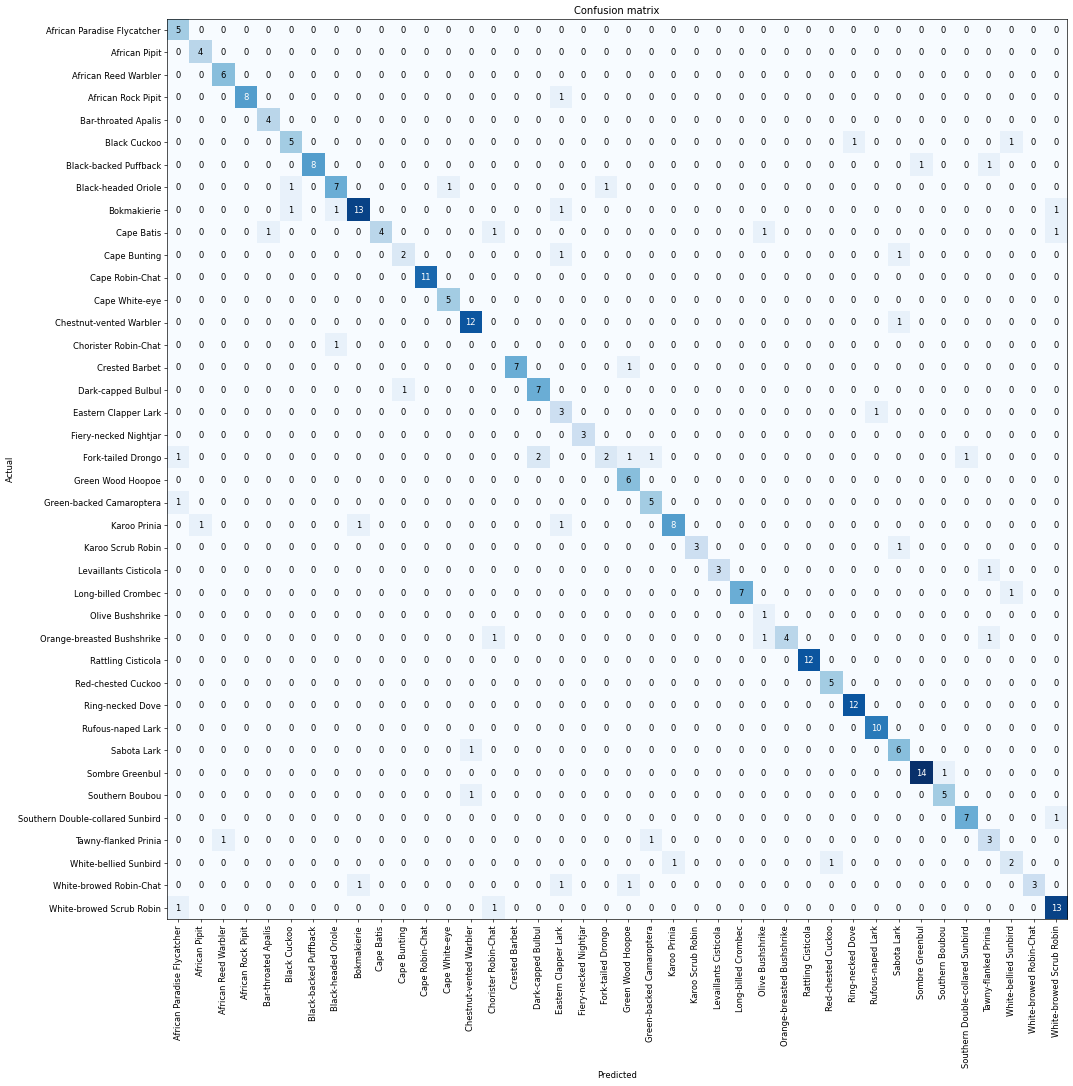

In [29]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(18,18), dpi=60)

# Making a submission

Save the model's predicted probabilities to a file following the sample submission format. This can be submitted on Zindi.

In [0]:
# Add the test data as a test set for the model
src = (ImageList.from_df(path='', df=test, cols='img_path')) # Note test, not sub, as we only have spectrograms for the ims in test
learn.data.add_test(src)

In [31]:
test.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,Bokmakierie,Black-backed Puffback,Southern Boubou,Black-headed Oriole,Fork-tailed Drongo,African Paradise Flycatcher,Sabota Lark,Eastern Clapper Lark,Rufous-naped Lark,Dark-capped Bulbul,Sombre Greenbul,Long-billed Crombec,African Reed Warbler,Rattling Cisticola,Levaillants Cisticola,Tawny-flanked Prinia,Karoo Prinia,Bar-throated Apalis,Green-backed Camaroptera,Chestnut-vented Warbler,Cape White-eye,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting,file_name,img_path
0,019OYB,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/My Drive/fowl/Test/019OYB.mp3,drive/My Drive/fowl/Test/019OYB_MEL.pkl
1,01S9OX,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/My Drive/fowl/Test/01S9OX.mp3,drive/My Drive/fowl/Test/01S9OX_MEL.pkl
2,02CS12,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/My Drive/fowl/Test/02CS12.mp3,drive/My Drive/fowl/Test/02CS12_MEL.pkl
3,02LM3W,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/My Drive/fowl/Test/02LM3W.mp3,drive/My Drive/fowl/Test/02LM3W_MEL.pkl
4,0C3A2V,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,drive/My Drive/fowl/Test/0C3A2V.mp3,drive/My Drive/fowl/Test/0C3A2V_MEL.pkl


In [32]:
# Get predictions
preds, y = learn.get_preds(DatasetType.Test)

In [0]:
(preds,_,e_) = get_TTA(tta=100 , ds="test")

In [0]:
# Add preds to test
test = test.copy()
for b in birds:
  test[b] = preds[:,learn.data.classes.index(b)]
test.head()

In [35]:
# Merge back into submission DF, adding a low prob prediction for rows where we had no image generated
cols = ['ID']
for b in birds:
  cols.append(b)
ss = pd.merge(sub['ID'], test[cols], on='ID', how='left' )
ss = ss.fillna(1/40) # For those with NaNs (if you only generated spectrograms for a subset of the test mp3s)
ss.head()

,ID,Ring-necked Dove,Black Cuckoo,Red-chested Cuckoo,Fiery-necked Nightjar,Green Wood Hoopoe,Crested Barbet,Cape Batis,Olive Bushshrike,Orange-breasted Bushshrike,Bokmakierie,Black-backed Puffback,Southern Boubou,Black-headed Oriole,Fork-tailed Drongo,African Paradise Flycatcher,Sabota Lark,Eastern Clapper Lark,Rufous-naped Lark,Dark-capped Bulbul,Sombre Greenbul,Long-billed Crombec,African Reed Warbler,Rattling Cisticola,Levaillants Cisticola,Tawny-flanked Prinia,Karoo Prinia,Bar-throated Apalis,Green-backed Camaroptera,Chestnut-vented Warbler,Cape White-eye,Karoo Scrub Robin,White-browed Scrub Robin,Cape Robin-Chat,White-browed Robin-Chat,Chorister Robin-Chat,Southern Double-collared Sunbird,White-bellied Sunbird,African Pipit,African Rock Pipit,Cape Bunting
0,019OYB,5.100551e-06,4.145905e-04,6.956507e-05,9.986898e-01,9.821339e-07,1.005616e-05,1.604766e-05,0.000001,5.512706e-05,4.755043e-06,0.000005,0.000027,2.591682e-05,0.000003,0.000011,2.901299e-05,5.575873e-06,0.000007,2.212163e-05,0.000008,1.051319e-05,9.042154e-06,0.000010,1.024013e-05,0.000004,0.000316,2.495776e-06,0.000017,1.035864e-05,0.000008,0.000004,0.000106,9.394323e-07,0.000035,0.000006,0.000004,0.000004,0.000009,0.000020,0.000004
1,01S9OX,1.454128e-03,1.729652e-04,6.286281e-04,7.181960e-04,1.210612e-03,1.925639e-03,4.686640e-04,0.002500,7.289534e-04,1.589313e-02,0.298352,0.007352,2.355805e-03,0.012411,0.000836,1.661087e-02,1.719954e-03,0.007189,4.461415e-03,0.001560,1.041919e-03,4.868155e-04,0.003190,8.340189e-04,0.000364,0.001737,6.687734e-04,0.001356,5.575373e-01,0.001970,0.009085,0.025182,1.023282e-02,0.001747,0.001149,0.000712,0.000372,0.000501,0.002664,0.000622
2,02CS12,5.164811e-04,1.226983e-03,9.692298e-04,2.940812e-03,2.231478e-03,3.952458e-03,9.273008e-04,0.003894,4.149467e-03,5.014661e-03,0.006771,0.005531,1.671916e-03,0.160544,0.004362,4.330440e-03,7.814760e-03,0.003982,5.485901e-03,0.008517,9.360363e-04,1.276404e-01,0.003242,1.033064e-03,0.001963,0.132702,4.202726e-03,0.004220,4.451545e-01,0.001206,0.013338,0.004813,1.310042e-03,0.002527,0.000412,0.001927,0.001336,0.003499,0.010781,0.002923
3,02LM3W,2.274798e-04,1.251302e-04,2.971431e-05,1.473543e-05,2.440114e-05,2.364003e-04,7.488665e-05,0.978318,3.188111e-04,1.543098e-02,0.000081,0.000141,3.668261e-04,0.000113,0.000009,2.134347e-05,1.607201e-04,0.000105,2.151058e-05,0.000040,9.239664e-05,7.350001e-05,0.000283,6.191456e-05,0.001009,0.000264,7.792875e-06,0.000470,3.610273e-05,0.000015,0.000405,0.000481,8.013535e-05,0.000032,0.000063,0.000026,0.000443,0.000074,0.000024,0.000199
4,0C3A2V,7.892309e-07,6.568826e-07,4.761280e-07,3.343373e-07,1.494234e-06,5.755524e-07,7.548637e-07,0.000002,1.992535e-07,1.090731e-07,0.000005,0.000002,2.058143e-07,0.000001,0.000001,5.112150e-07,6.047571e-07,0.000004,6.896523e-07,0.000001,7.624654e-07,7.449950e-08,0.000001,7.101303e-07,0.000001,0.000002,6.612631e-08,0.000007,8.280894e-07,0.000436,0.000067,0.000002,9.993666e-01,0.000017,0.000002,0.000003,0.000062,0.000004,0.000001,0.000002


In [36]:
# Check shape
ss.shape

(911, 41)

In [0]:
# Save 
ss.to_csv('drive/My Drive/fowl/submission_starter_notebook2.csv', index=False)

# How To Get Better

Hopefully, this has got you started and given you an idea of what the data for this competition looks like. The submission we've just generated should score ~2.7 on the leaderboard (the validation loss tracks pretty closely with the Zindi score since it's also log_loss). But where do you go from here? Here are some ideas:

### 1) Refining the process above

The above method (training an image classifier on spectrograms) can do decently. Some ways to improve the score:
- Increase the image size
- Train a little more, or try different models
- 'Crop' the inputs, both to show a shorter clip of audio and a smaller frequency range
- Experiment with different ways of displaying the spectrgram. Log scale on the frequency axis. More striking colour maps. Maybe some audio cleaning and pre-processing...

### 2) Extracting other features

Look at other approaches people take for audio ML tasks. Mel Spectrograms, amplitude plots, various acoustic parameters... there's a whole world of audio-related weirdness you can explore. These kinds of features can then be fed into your ML algorithm of choice. 

### 3) Boost training data quality by detecting 'events'

Consider the following image:

![spectrogram image](https://www.xeno-canto.org/sounds/uploaded/XRABICUARW/ffts/XC3962-large.png)

You can see four clear signals (calls) separated by noise. You'll notice this in many of the training recordings. Rather than ~30 recordings per species, you could find a way to detect such events and clip the audio files, to give you hundreds of exaple calls, each neatly isolated from the longer recordings. This has the potential to massively improve performance. 

### 4) Tackle 'background calls'

I haven't explored this avenue at all, but finding a way to account for the occasional presence of extra birds calling in the background when making your predictions might give you a slight extra edge.

### 5) Make friends with someone who does Signal Processing

There are signal processing techniques that seem like magic to anyone not used to thinking in the fourier domain. I don't have specific recommendations for things to check out here, but if you do happen to know somebody with skills in this area I suspect it'll be worth offering them a share of your glory in exchange for some tips. :)

### 6) Look around to see what the State of the Art is for audio classification

Using an image recognition pipeline for audio classification is a bit of a hack. Take a look at some recent publications to see what the cool kids are using. 

### 7) Get creative!

I'm hoping the winner doesn't just take some of the advice above and follow a standard bird call classification path. There are so many ways to approach this problem, and the best way is likely still undiscovered!

Good luck :)